<center><h1><font size=6> Exploratory Data Analysis (EDA) </h1></center>

### Load libraries and setup notebook configuration

In [1]:
# import packages
import pandas as pd 
import numpy as np
import os
from pathlib import Path
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math


# set pandas configurations
pd.set_option("display.precision", 2) # display to 1 decimpal place
pd.set_option("display.max.columns", None) # display all columns so we can view the whole dataset
pd.set_option('display.float_format', '{:.2f}'.format) # Disable scientific notation for pandas
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning) # Disable setting with copy warnings


# set directories
os.chdir('..') # change current working directory to the parent directory to help access files/directories at a higher level
DATAPATH = Path(r'data') # set data path


# import from source directory
from src import constants

### Load training data from local file

In [2]:
X_train_full = pd.read_csv(f"{DATAPATH}/processed/X_train_full.csv")
y_train_full = pd.read_csv(f"{DATAPATH}/processed/y_train_full.csv")
X_train_short = pd.read_csv(f"{DATAPATH}/processed/X_train_short.csv")
y_train_short = pd.read_csv(f"{DATAPATH}/processed/y_train_short.csv")
eda_full = X_train_full.merge(y_train_full, on='unique_match_id', how='left')
eda_short = X_train_short.merge(y_train_short, on='unique_match_id', how='left')

### Check for duplicate values

In [3]:
duplicates = eda_full.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


### Check for any missing values

In [9]:
missing_values = eda_full.isnull().sum()
print("Missing value count by column:")
print(missing_values)

Missing value count by column:
unique_match_id                           0
season                                    0
date                                      0
day_of_week                               0
time                                  13015
round                                     0
day                                       0
team                                      0
promoted                                  0
opponent                                  0
promoted_opponent                         0
home                                      0
days_since_last_game                    434
games_played_last_21_days               465
pl_total_points                           4
pl_total_gf                               4
pl_total_ga                               4
pl_total_goal_diff                        4
pl_position                             173
last_h2h                                529
last_h2h_form                           529
last_h2h_venue                         1054
l

### Check the distribution of missing values

Wrap the below into a function and plot the distribution across things like:
- season
- gameweek round
- team
- promoted


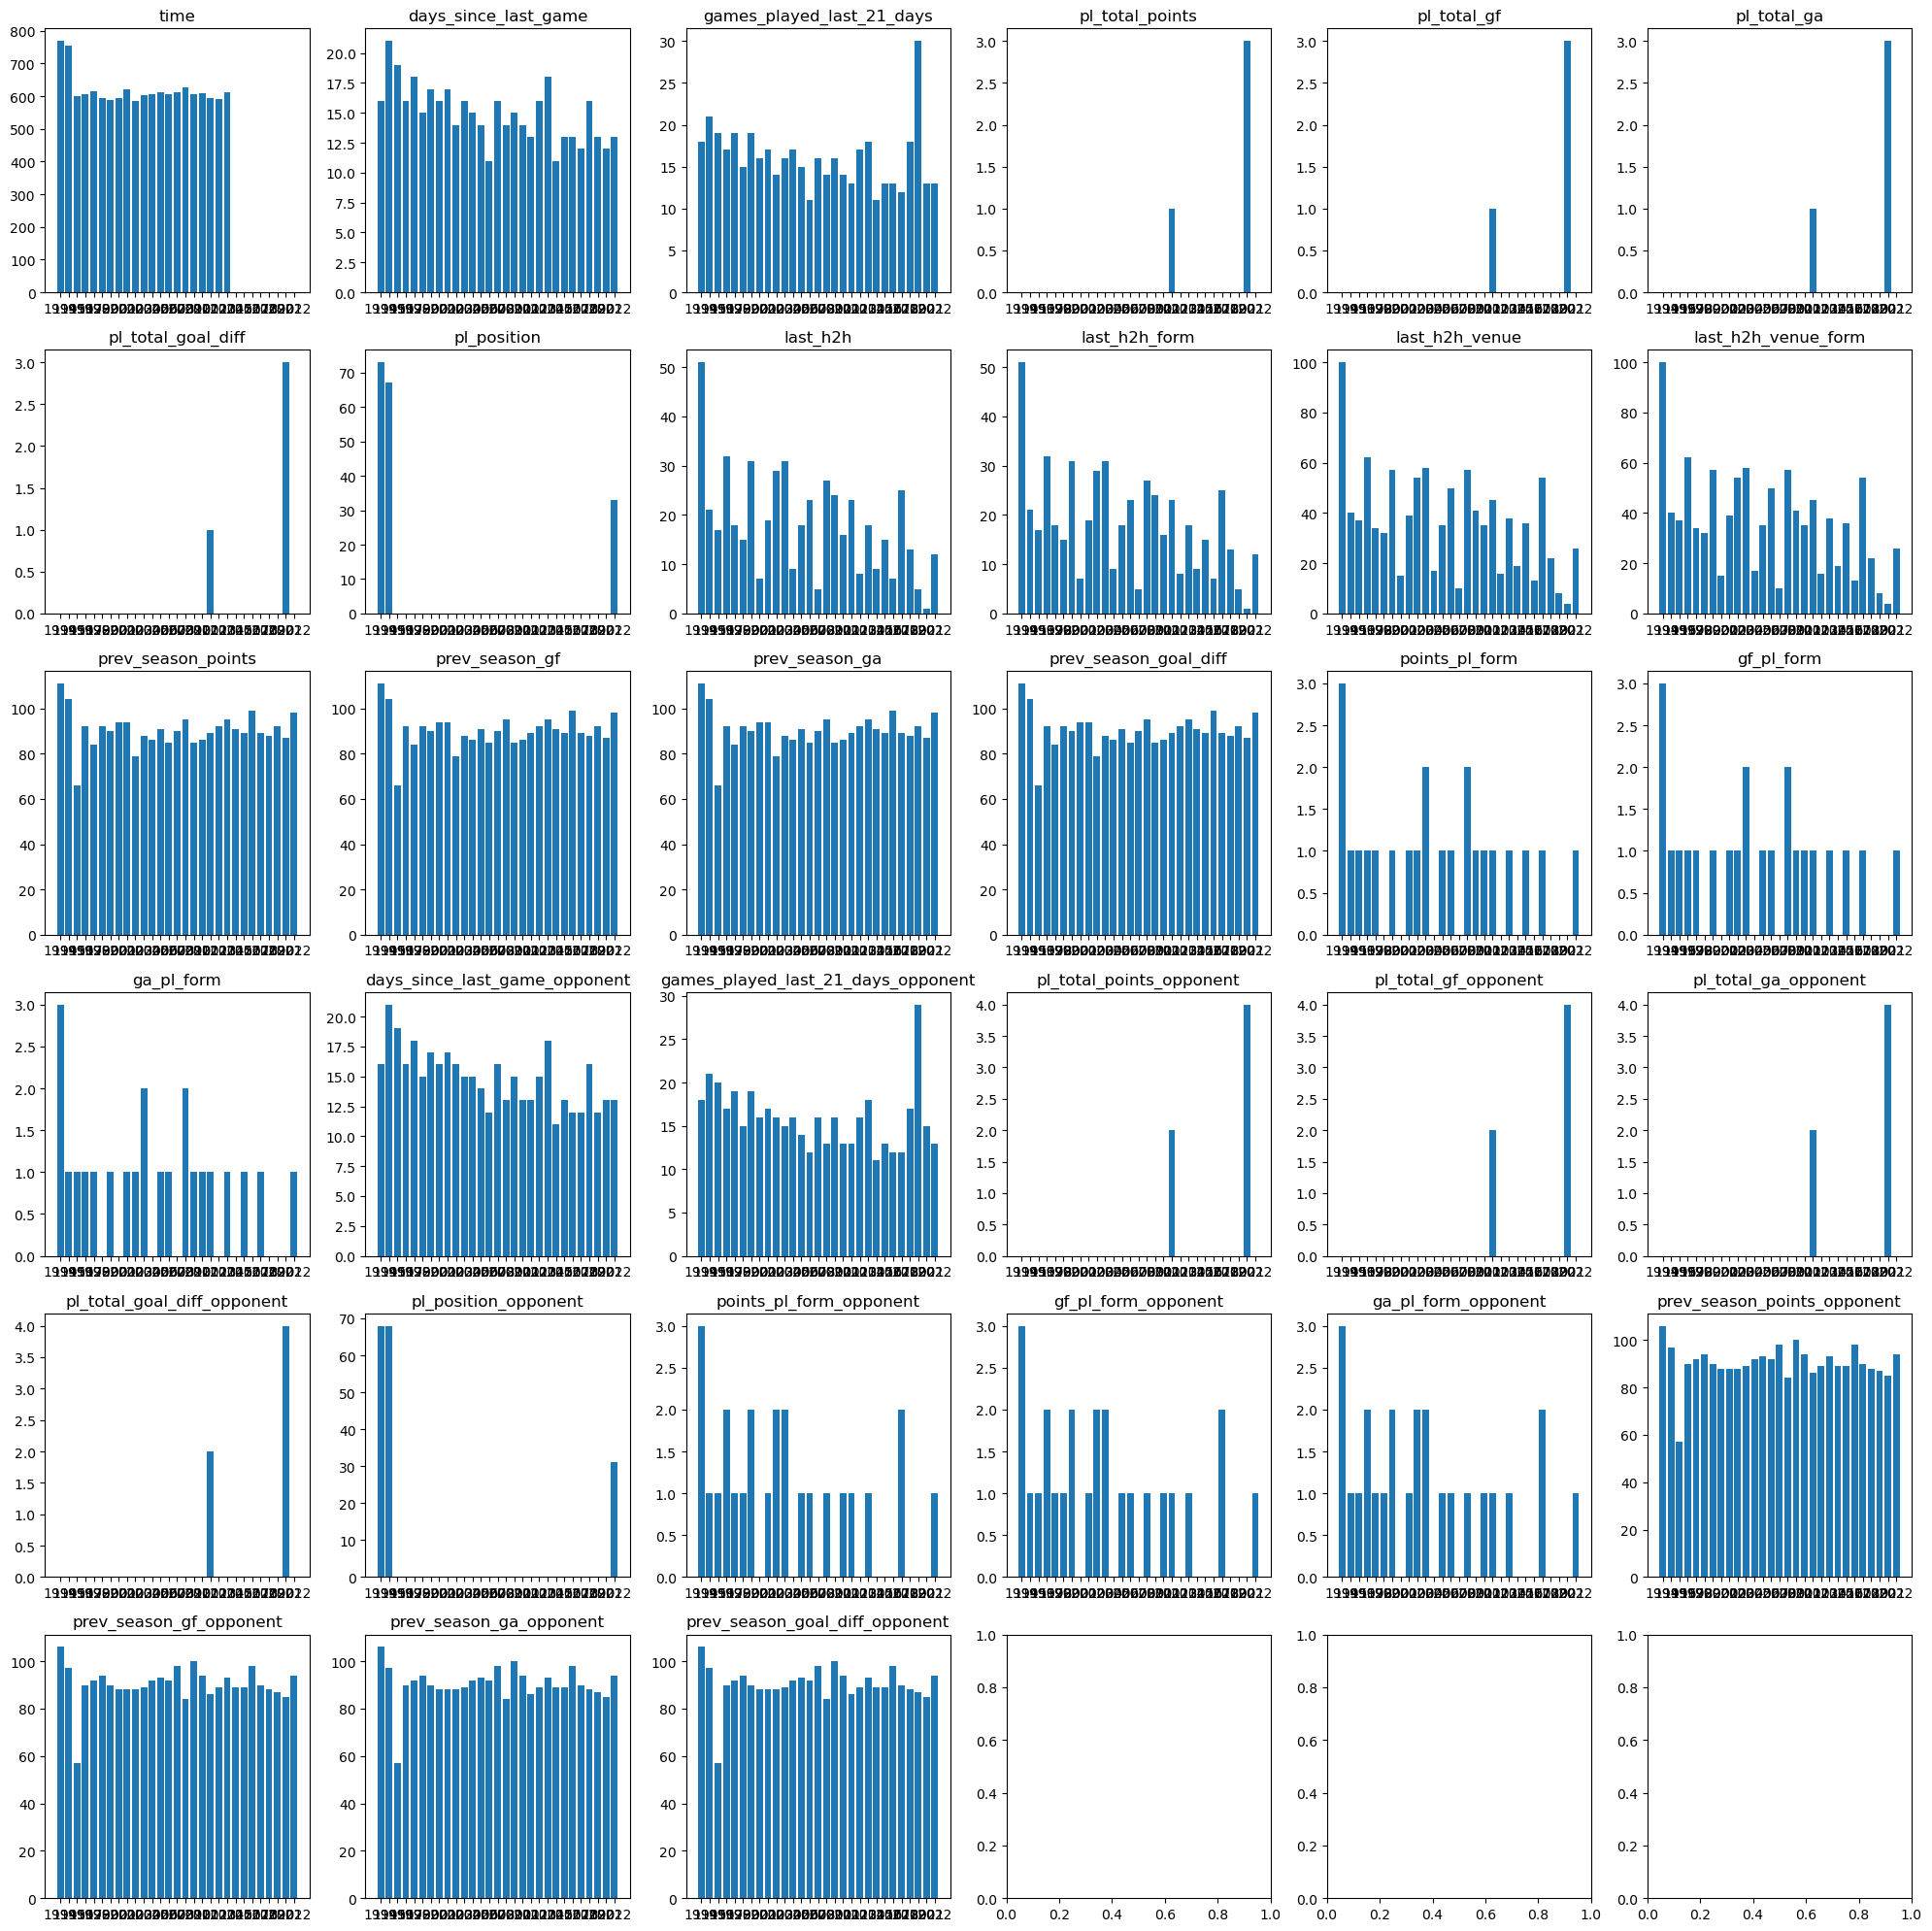

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Calculate the number of missing values for each column grouped by season
missing_values_by_season = eda_full.groupby('season').apply(lambda x: x.isnull().sum())

# remove any columns that don't have any missing values
column_sums = missing_values_by_season.sum() # Calculate the sum of each column
nonzero_columns = column_sums[column_sums != 0] # Filter out columns where the sum is equal to 0
missing_values_by_season = missing_values_by_season.loc[:, nonzero_columns.index] # Select only the columns with nonzero sum

# Reset index to make season a column
missing_values_by_season = missing_values_by_season.reset_index()

# Melt the data frame to create a variable column for each column with missing values
melted_df = missing_values_by_season.melt(id_vars='season', var_name='variable', value_name='missing_values')
melted_df = melted_df[['variable', 'season', 'missing_values']]

# Create a list of variables for plotting
variables = melted_df['variable'].unique().tolist()

n_col = 5
n_variables = len(variables)
grid_size = math.ceil(math.sqrt(n_variables))

# Create a figure and grid layout
fig, axs = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(20, 20))

# Iterate over the columns and create bar charts in each subplot
for i, col in enumerate(variables):
    
    # Get the subplot axes
    ax = axs[i // grid_size, i % grid_size]
    
    # Retrieve the data for the current column
    data = melted_df[melted_df['variable'] == col]
    
    # Get the seasons and missing values for the current column
    seasons = data['season']
    missing_values = data['missing_values']
    
    # Set the x-axis ticks and labels
    x_ticks = np.arange(len(seasons))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(seasons)
    
    # Plot the bar chart
    ax.bar(x_ticks, missing_values)
    
    # Set the title for the subplot
    ax.set_title(col)

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

In [95]:
len(variables)

33